#### Christian Altrichter, Jury Andrea D'Onofrio, Francesco Huber

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(4,suppress=True)

In [4]:
def cv2_imshow(imgz, title=None, cmap='gray'):
    plt.imshow(imgz, cmap=cmap)
    if title is not None:
        plt.title(title)
    plt.show()

## Task 1.
Find the image coordinates xi , i = 1, . . . , 10, of the points marked in the image above (either by detecting lines with the Hough transform and intersecting them or by reading them off the image ”house1.png” manually).

In [5]:
def plot_points(image, points, title=''):
    fig, ax = plt.subplots()
    ax.imshow(image)
    for i, point in enumerate(points):
        ax.scatter(point[0],point[1],color="red", label=i+1, marker='.')
        plt.text(point[0],point[1], s=i+1, color='white', size= 'medium')
    plt.title(title)
    plt.figure(figsize=(20,20))
    plt.show()

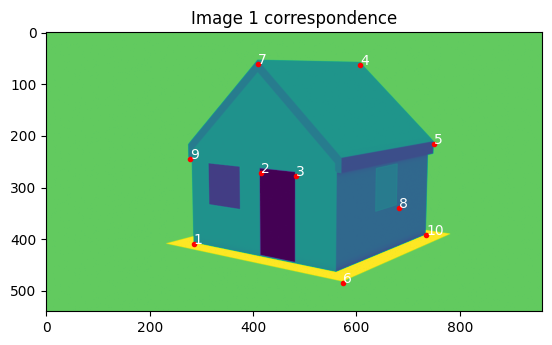

<Figure size 2000x2000 with 0 Axes>

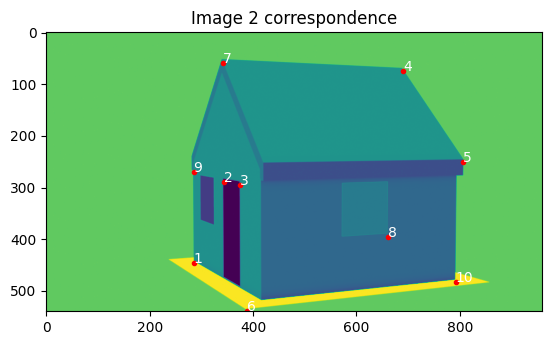

<Figure size 2000x2000 with 0 Axes>

In [6]:
image1_points = [[285,410],
                [415,271], 
                [483,277], 
                [608,62], 
                [750, 215], 
                [575,485],
                [410,60],
                [682,340],
                [278,245],
                [735, 392]]

plot_points(cv2.imread("house1.png", 0), image1_points, "Image 1 correspondence")


image2_points = [[285,446], 
                [344,290], 
                [375,295], 
                [690,75], 
                [806, 251], 
                [388,538],
                [341,59],
                [662,395],
                [285, 270],
                [792,482]]

plot_points(cv2.imread("house2.png", 0), image2_points, "Image 2 correspondence")

world_points = [
    [-1.0 ,-1.0, 0.0, 1.0],
    [0.015545, -1.0, 0.965257, 1.0],
    [0.491684, -1.0, 0.965257, 1.0],
    [0.0, 1.03586, 2.1009, 1.0],
    [1.05319, 1.03586, 1.15121, 1.0],
    [1.22323, -1.22323, 0.0, 1.0],
    [0.0, -1.0, 2.1009, 1.0],
    [1.0, 0.234552, 0.489472, 1.0],
    [-1.05319, -1.0, 1.0, 1.0],
    [1.0, 1.0, 0.0, 1.0]
    ]


## Task 2.
Reconstruct the projection matrix P using the DLT algorithm. Do not worry if the rank of the matrix A that is involved is not 11. In practice, a slight imprecision in the coordinates is enough to turn it into a rank 12 matrix, but taking as p (the R12 vector with the coefficients of P ) the last column of V (not of VT)of the singular value decomposition A=UΣVT is still the way to go.

In [7]:
# Projection matrix P is a 3x4
# instead of xj = PXj, we only need  𝜆xj = PXj for some 𝜆 != 0, therefore we can say xj * PXj = 0
def projection_matrix(world_coords, image_coords):

    # create a matrix A and fill it with zeros
    # A is of size 2n x 12
    # 2n because we have 2 image coordinates for every world coordinate
    # 12 because we have 11 parameters (so 11 DoF) plus 1
    A = np.zeros((2 * len(world_coords), 12))

    for i in range(len(world_coords)):
        X, Y, Z, _ = world_coords[i]
        x, y = image_coords[i]
        
        A[2 * i + 1, :]     = [-X, -Y, -Z, -1,    0,  0,  0,  0,    x * X, x * Y, x * Z, x]     # x
        A[2 * i, :]         = [ 0,  0,  0,  0,   -X, -Y, -Z, -1,    y * X, y * Y, y * Z, y]     # y

    # singular value decomposition A = UΣV^T
    #print("A\n:", A)
    _, _, V = np.linalg.svd(A)

    # last column of V and reshape it to 3x4, Note that the returned V is transposed so the last column is actually the last row
    p = V[-1, :]

    # norm of p must is 1
    # print("p norm" ,np.linalg.norm(p))
    p_matrix = p.reshape((3, 4))
    return p_matrix


def compare_points(camera_points, Proj_m):
    # Prints the predicted 2D points based on 3D world coordinates and our P
    print("\nPoint comparison by x = PX")
    for i in range(len(world_points)):
        point = Proj_m @ world_points[i]
        print("point", i+1)
        print(np.round((point/point[-1])[:-1]),
              "vs manually selected",
              camera_points[i])
        print()
    print("----------------------------------\n")


In [8]:
P = projection_matrix(world_points, image1_points)
print("Projection matrix P:\n", P)
# Verification of x = PX
compare_points(image1_points, P)

Projection matrix P:
 [[ 0.1384  0.2051 -0.0136  0.7431]
 [-0.0045  0.0092 -0.2337  0.5759]
 [-0.0001  0.0001 -0.      0.0014]]

Point comparison by x = PX
point 1
[287. 410.] vs manually selected [285, 410]

point 2
[415. 268.] vs manually selected [415, 271]

point 3
[484. 277.] vs manually selected [483, 277]

point 4
[609.  62.] vs manually selected [608, 62]

point 5
[750. 215.] vs manually selected [750, 215]

point 6
[576. 487.] vs manually selected [575, 485]

point 7
[410.  61.] vs manually selected [410, 60]

point 8
[679. 338.] vs manually selected [682, 340]

point 9
[276. 246.] vs manually selected [278, 245]

point 10
[735. 393.] vs manually selected [735, 392]

----------------------------------



## Task 3.
Recover the camera calibration matrix K, the camera orientation R and the (non-homogeneous) world coordinates Ce of the camera from P . Make sure that the diagonal values of K are positive in your solution by suitably adapting R.

In [9]:
def get_K_R_C(projection_m):
    # P is K [R|-RC]

    # 17. CALIBRATION SLIDE 60
    # Apply RQ decomposition
    Π = np.array([[0, 0, 1],
                  [0, 1, 0],
                  [1, 0, 0]])

    M = projection_m[:, :3]
    Q, R_ = np.linalg.qr(M.transpose() @ Π)


    K = Π @ R_.transpose() @ Π
    R = Π @ Q.transpose()

    #Slide Deck 16. Slide 54
    K = K/K[-1,-1]

    # Extract C = (−M^(-1) @ p4, 1).transposed()
    p4 = projection_m[:,-1]
    C = (-np.linalg.inv(M) @ p4)

    return K, R, C

In [10]:
# Decomposition of P
K, R, C = get_K_R_C(P)

print("Calibration matrix K normalized:")
print(K)

print("\nCamera orientation matrix R:")
print(R)

print("\nNon-homogeneous world coordinates C:")
print(C)


Calibration matrix K normalized:
[[-1354.4565     6.1987   528.5405]
 [    0.      1345.1017   272.8836]
 [    0.         0.         1.    ]]

Camera orientation matrix R:
[[-0.8196 -0.573  -0.0067]
 [ 0.095  -0.1243 -0.9877]
 [-0.5651  0.8101 -0.1563]]

Non-homogeneous world coordinates C:
[ 4.7427 -6.6825  2.1104]


In [11]:
# Make sure that the diagonal values of K are positive in your solution by suitably adapting R.
# To fix K negative diagonal values, we must flip sign of the corresponding column on K and row on R
def fix_negative_diagonals_K(K,R):
    K_adj = np.copy(K)
    R_adj = np.copy(R)

    for i in range(3):
        if K[i,i] < 0:
            R_adj[i,:] *= -1
            K_adj[:,i] *= -1

    return K_adj, R_adj

In [12]:
K_adj, R_adj = fix_negative_diagonals_K(K,R)

print("Old K:\n", K, "\n")
print("Adjusted K:\n",K_adj, "\n")
print()

print("Old R:\n",R)
print("Old determinant:", np.round(np.linalg.det(R)), "\n")
print("Adjusted R:\n",R_adj)
print("New determinant:", np.round(np.linalg.det(R_adj)), "\n")


Old K:
 [[-1354.4565     6.1987   528.5405]
 [    0.      1345.1017   272.8836]
 [    0.         0.         1.    ]] 

Adjusted K:
 [[1354.4565    6.1987  528.5405]
 [  -0.     1345.1017  272.8836]
 [  -0.        0.        1.    ]] 


Old R:
 [[-0.8196 -0.573  -0.0067]
 [ 0.095  -0.1243 -0.9877]
 [-0.5651  0.8101 -0.1563]]
Old determinant: -1.0 

Adjusted R:
 [[ 0.8196  0.573   0.0067]
 [ 0.095  -0.1243 -0.9877]
 [-0.5651  0.8101 -0.1563]]
New determinant: 1.0 



In [13]:
# Projection matrix P is a 3x4
P2 = projection_matrix(world_points, image2_points)

print("P Image 2:\n", P2)

compare_points(image2_points, P2)

K2, R2, C2 = get_K_R_C(P2)

print("Calibration matrix K2:\n", K2, "\n")


print("\nCamera orientation matrix R2:")
print(R2)

print("R2 determinant:", np.round(np.linalg.det(R2)))

print("\nNon-homogeneous world coordinates C2:")
print(C2)


P Image 2:
 [[-0.0243 -0.2649  0.004  -0.6962]
 [ 0.0318 -0.015   0.2512 -0.6166]
 [ 0.0002 -0.0001  0.     -0.0013]]

Point comparison by x = PX
point 1
[287. 446.] vs manually selected [285, 446]

point 2
[344. 288.] vs manually selected [344, 290]

point 3
[377. 294.] vs manually selected [375, 295]

point 4
[690.  75.] vs manually selected [690, 75]

point 5
[807. 252.] vs manually selected [806, 251]

point 6
[387. 539.] vs manually selected [388, 538]

point 7
[341.  60.] vs manually selected [341, 59]

point 8
[661. 394.] vs manually selected [662, 395]

point 9
[283. 270.] vs manually selected [285, 270]

point 10
[792. 482.] vs manually selected [792, 482]

----------------------------------

Calibration matrix K2:
 [[-1381.8476     0.8099   497.1722]
 [   -0.      1376.6241   254.218 ]
 [   -0.        -0.         1.    ]] 


Camera orientation matrix R2:
[[-0.4229 -0.9062 -0.0005]
 [ 0.0398 -0.0181 -0.999 ]
 [-0.9053  0.4225 -0.0437]]
R2 determinant: -1.0

Non-homogeneous wor

In [14]:
K_adj2, R_adj2 = fix_negative_diagonals_K(K2,R2)

print("Old K:\n", K2, "\n")
print("Adjusted K:\n",K_adj2, "\n")
print()

print("Old R:\n",R2)
print("Old determinant:", np.round(np.linalg.det(R2)), "\n")
print("Adjusted R:\n",R_adj2)
print("New determinant:", np.round(np.linalg.det(R_adj2)), "\n")


Old K:
 [[-1381.8476     0.8099   497.1722]
 [   -0.      1376.6241   254.218 ]
 [   -0.        -0.         1.    ]] 

Adjusted K:
 [[1381.8476    0.8099  497.1722]
 [   0.     1376.6241  254.218 ]
 [   0.       -0.        1.    ]] 


Old R:
 [[-0.4229 -0.9062 -0.0005]
 [ 0.0398 -0.0181 -0.999 ]
 [-0.9053  0.4225 -0.0437]]
Old determinant: -1.0 

Adjusted R:
 [[ 0.4229  0.9062  0.0005]
 [ 0.0398 -0.0181 -0.999 ]
 [-0.9053  0.4225 -0.0437]]
New determinant: 1.0 



## Project Part 2. Results

In [15]:
print("\nIMAGE 1 Values:")
print("K:\n", K_adj,"\n")
print("R:\n", R_adj,"\n")
print("C:\n", C,"\n")

print("--------------------")


print("\nIMAGE 2 Values:")
print("K:\n", K_adj2,"\n")
print("R:\n", R_adj2,"\n")
print("C:\n", C2,"\n")


IMAGE 1 Values:
K:
 [[1354.4565    6.1987  528.5405]
 [  -0.     1345.1017  272.8836]
 [  -0.        0.        1.    ]] 

R:
 [[ 0.8196  0.573   0.0067]
 [ 0.095  -0.1243 -0.9877]
 [-0.5651  0.8101 -0.1563]] 

C:
 [ 4.7427 -6.6825  2.1104] 

--------------------

IMAGE 2 Values:
K:
 [[1381.8476    0.8099  497.1722]
 [   0.     1376.6241  254.218 ]
 [   0.       -0.        1.    ]] 

R:
 [[ 0.4229  0.9062  0.0005]
 [ 0.0398 -0.0181 -0.999 ]
 [-0.9053  0.4225 -0.0437]] 

C:
 [ 6.5535 -3.2084  1.4354] 



## METRIC RECTIFICATION

In [184]:
import cv2
#HELPER FUNCTIONS
def plot_points(image, points, title=''):
    fig, ax = plt.subplots()
    ax.imshow(image)
    for i, point in enumerate(points):
        ax.scatter(point[0],point[1],color="red", label=i+1, marker='.')
        plt.text(point[0],point[1], s=i+1, color='white', size= 'medium')
    plt.title(title)
    plt.figure(figsize=(13,13))
    plt.show()

# Apply Bi-linear interpolation to map the points from our orginal image under the Matrix H (here A) and an affine transformation T
# Taken from iCorsi
def apply_inv_map(A, _image):
    A1 = np.copy(_image)
    # Get height and width of source image
    M1 = A1.shape[0]
    N1 = A1.shape[1]

    # Set height and width of target image
    M2 = M1
    N2 = N1
    A2 = np.zeros((M2, N2))

    # Set default intensity to white
    A2[:, :] = 255

    #A = np.matmul(T,A)
    #A = np.identity(n=3)
    A = np.linalg.inv(A)
    #print(H*A)

    #Transformation with inverse mapping and bilinear interpolation
    for i in range(0, M2):
        for j in range(0, N2):
            # coordinates of the (i,j)-th pixel in A2
            x = i + 0.5
            y = j + 0.5

            # convert to homogeneous coordinates
            p = np.array([x, y, 1])
            # transform with matrix A
            q = np.matmul(A, p)

            # coordinates in A1
            x = q[0] / q[-1]
            y = q[1] / q[-1]

            # bilinear interpolation
            k = round(x) - 1
            l = round(y) - 1
            u = x - k - 0.5
            v = y - l - 0.5
            if (k >= 0) and (k < M1 - 1) and (l >= 0) and (l < N1 - 1):
                A2[i, j] = round((1 - v) * ((1 - u) * A1[k, l] + u * A1[k + 1, l]) +
                                 v * ((1 - u) * A1[k, l + 1] + u * A1[k + 1, l + 1]))

    return A2

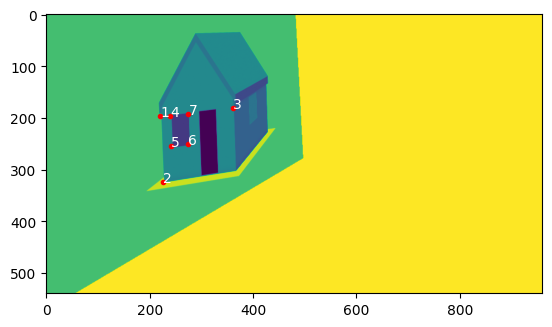

<Figure size 1300x1300 with 0 Axes>

In [203]:
rectified = cv2.imread("affine_rec.png", 0)

points = [
          [220,197, 1],   #1
          [225, 325, 1],  #2
          [362, 180,1],   #3

          [240,197, 1],   #5
          [242, 255, 1],  #6
          [275, 250, 1],  #7
          [275, 192, 1],  #8
          ]  #


plot_points(rectified,points)

In [186]:
# first set of orthogonal lines
#P1-P2, P1-P3
line1 = np.cross(np.array([220,197, 1]), np.array([225, 325, 1]))

line2 = np.cross(np.array([220,197, 1]),np.array([362, 180,1]))

line1 = line1/line1[-1]
line2 = line2/line2[-1]

print("l1:", line1)
print("l2:", line2)

l1: [-0.0047  0.0002  1.    ]
l2: [-0.0005 -0.0045  1.    ]


In [189]:
# second set of orthogonal lines, cross-section of window
# P4-P6, P5-P7
line3 = np.cross(np.array([240,197, 1]), np.array([275, 250, 1]))
line4 = np.cross(np.array([242, 255, 1]),np.array([275, 192, 1]))

line3 = line3/line3[-1]
line4 = line4/line4[-1]

print("l3:",line3)
print("l4:",line4)

l3: [-0.0091  0.006   1.    ]
l4: [-0.0027 -0.0014  1.    ]


Text(0.5, 1.0, 'selected lines')

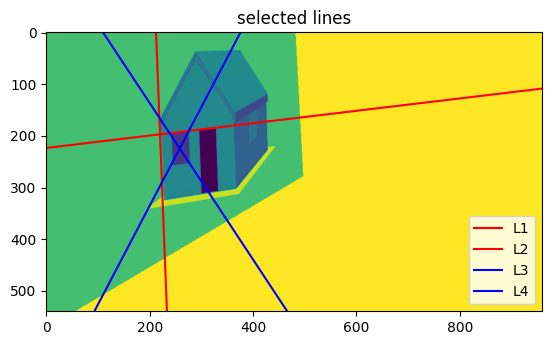

In [299]:
fig, ax = plt.subplots()
ax.imshow(rectified)
plt.axline((220,197), (225,325), color= "red", label= "L1")
plt.axline((220,197), (362,180), color= "red", label= "L2")
plt.axline((240,197), (275,250), color= "blue", label= "L3")
plt.axline((242,255), (275,192), color= "blue", label= "L4")
plt.legend()
plt.title("selected lines")

In [300]:
# Getting S via svd by constraining A with the various sets of lines
A = np.array([
                [line1[0]*line2[0], line1[0]*line2[1] + line1[1]*line2[0], line1[1] * line2[1]],
                [line3[0]*line4[0], line3[0]*line4[1] + line3[1]*line4[0], line3[1] * line4[1]]
             ])

_, _, V =  np.linalg.svd(A)
s = V[-1]

print(s)

S = np.array([[s[0], s[1]],
              [s[1], s[2]]])
print("S:\n", S, "\n")

#Useless
# C_inf_prime = np.vstack((np.hstack((S,np.zeros((2,1)))),
#                         np.zeros((1,3))))
# print(C_inf_prime)

[ 0.3266 -0.0022  0.9451]
S:
 [[ 0.3266 -0.0022]
 [-0.0022  0.9451]] 



In [301]:
# Getting K which is S = KKtrans
k3 = np.sqrt(s[-1])
k2 = s[1]/k3
k1 = np.sqrt(s[0]-k2**2)

print("k3", k3)
print("k2", k2)
print("k1", k1)

K = np.array([[k1,k2],
               [0,k3]])
print("K:\n",K, "\n")
print("K det:\n",np.linalg.det(K), "\n")

K = K/(np.sqrt(np.linalg.det(K)))
print("K forced det 1:\n",K, "\n")
print("new det", np.linalg.det(K), "\n")

k3 0.97218671737785
k2 -0.0022577912466665976
k1 0.5715179637345507
K:
 [[ 0.5715 -0.0023]
 [ 0.      0.9722]] 

K det:
 0.5556221730855659 

K forced det 1:
 [[ 0.7667 -0.003 ]
 [ 0.      1.3042]] 

new det 1.0 



In [302]:
# Getting corresponding Affine Transformation
HA = np.vstack( (np.hstack( (K, np.zeros((2,1)))) , np.zeros((1,3)) ) )

HA[-1,-1] = 1
print("H affine:\n", HA)

H affine:
 [[ 0.7667 -0.003   0.    ]
 [ 0.      1.3042  0.    ]
 [ 0.      0.      1.    ]]


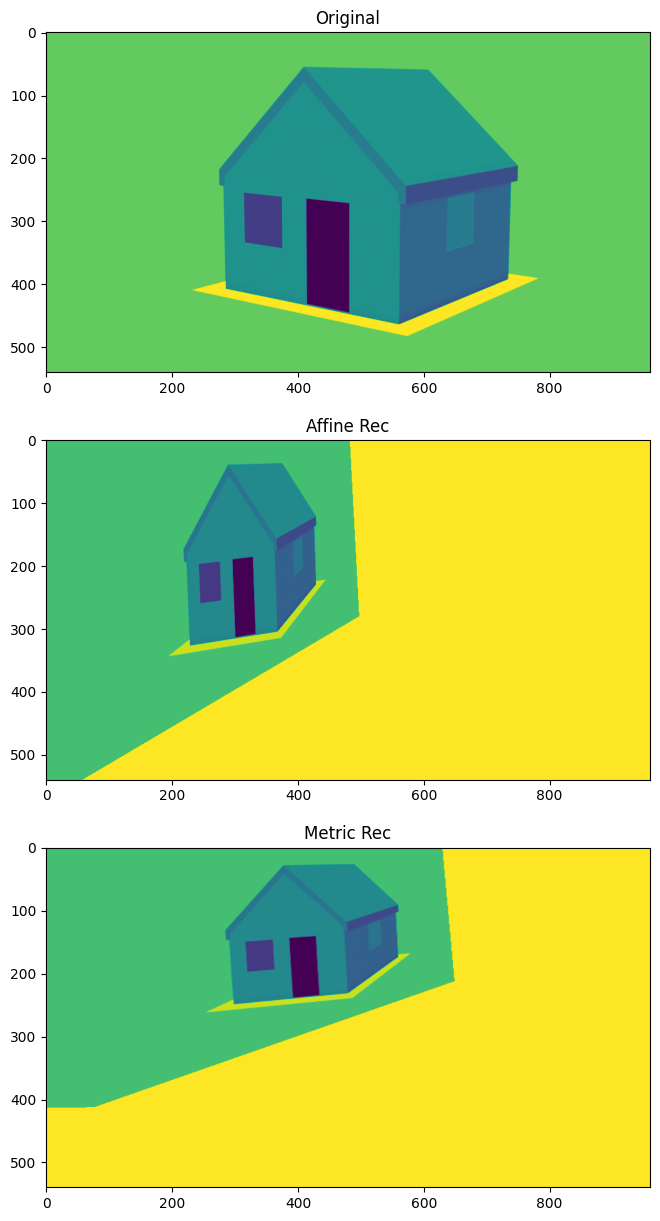

In [303]:
# Metric Rectification via: Ha_inv @ affine_rec_img
metric_rec = apply_inv_map(HA, rectified)
original = cv2.imread("house1.png", 0)

f, axs = plt.subplots(3,1)
axs[0].imshow(original)
axs[1].imshow(rectified)
axs[2].imshow(metric_rec)
axs[0].title.set_text('Original')
axs[1].title.set_text('Affine Rec')
axs[2].title.set_text('Metric Rec')
f.set_figheight(15)
f.set_figwidth(15)


Hs:
 [[  0.478   -0.0435  30.    ]
 [  0.0435   0.478  150.    ]
 [  0.       0.       1.    ]]


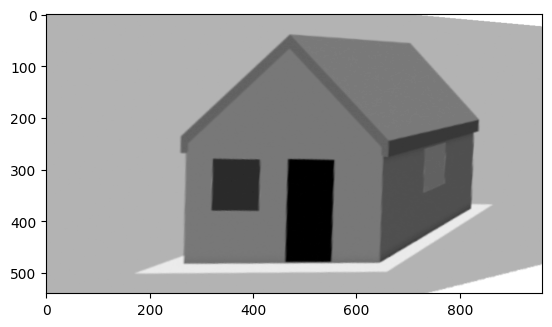

In [304]:
#Randomply trying to revert similarity
angle = 5.2
theta = angle * np.pi/180

R = np.array([  [np.cos(theta), -np.sin(theta), 0],
                [np.sin(theta),  np.cos(theta), 0],
                [            0,              0, 0]])

scal = .48

T = [[0,0,30],
     [0,0,150],
     [0,0,1]]

sR = scal * R
Hs = sR+T

print("Hs:\n", Hs)

Hs_inv = np.linalg.inv(Hs)

similarity_rect = apply_inv_map(Hs_inv, metric_rec)
cv2_imshow(similarity_rect)

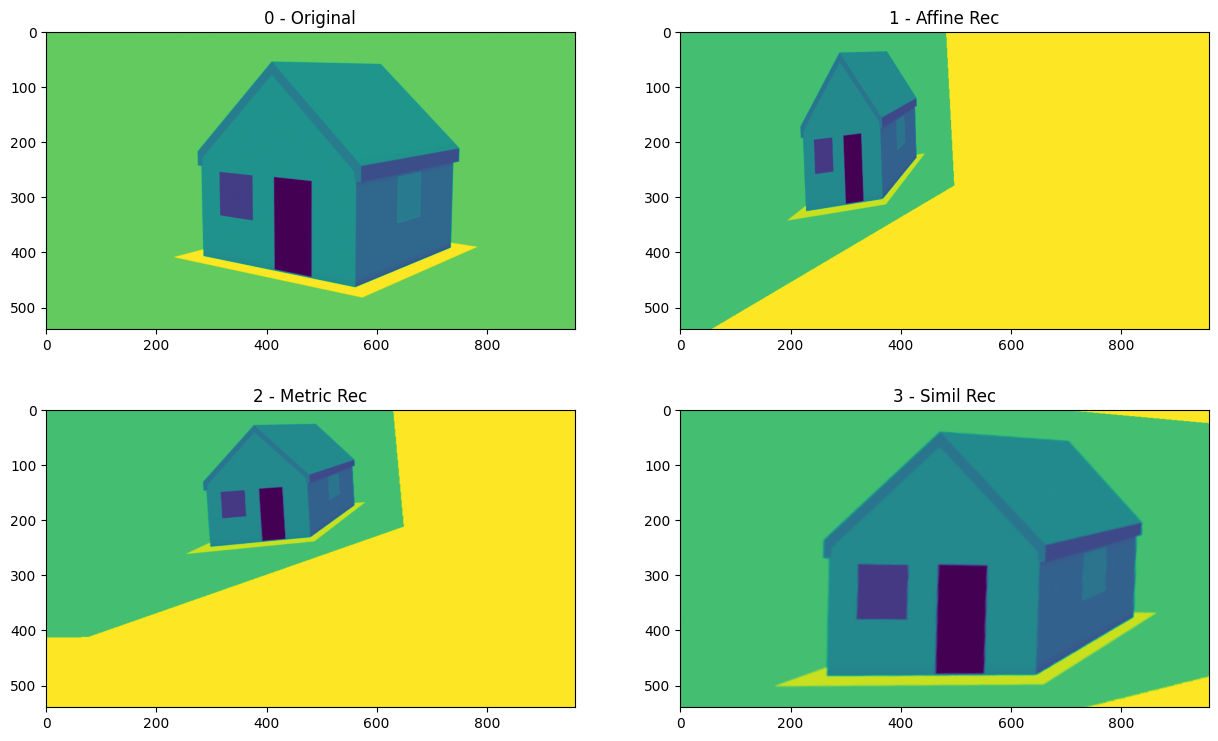

In [305]:
# ALL TOGETHER
f, axs = plt.subplots(2,2)
axs[0,0].imshow(original)
axs[0,1].imshow(rectified)
axs[1,0].imshow(metric_rec)
axs[1,1].imshow(similarity_rect)
axs[0,0].title.set_text('0 - Original')
axs[0,1].title.set_text('1 - Affine Rec')
axs[1,0].title.set_text('2 - Metric Rec')
axs[1,1].title.set_text('3 - Simil Rec')
f.set_figheight(9)
f.set_figwidth(15)